In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Работа OpenCV matchTemplate на шаблоне и основном изображении

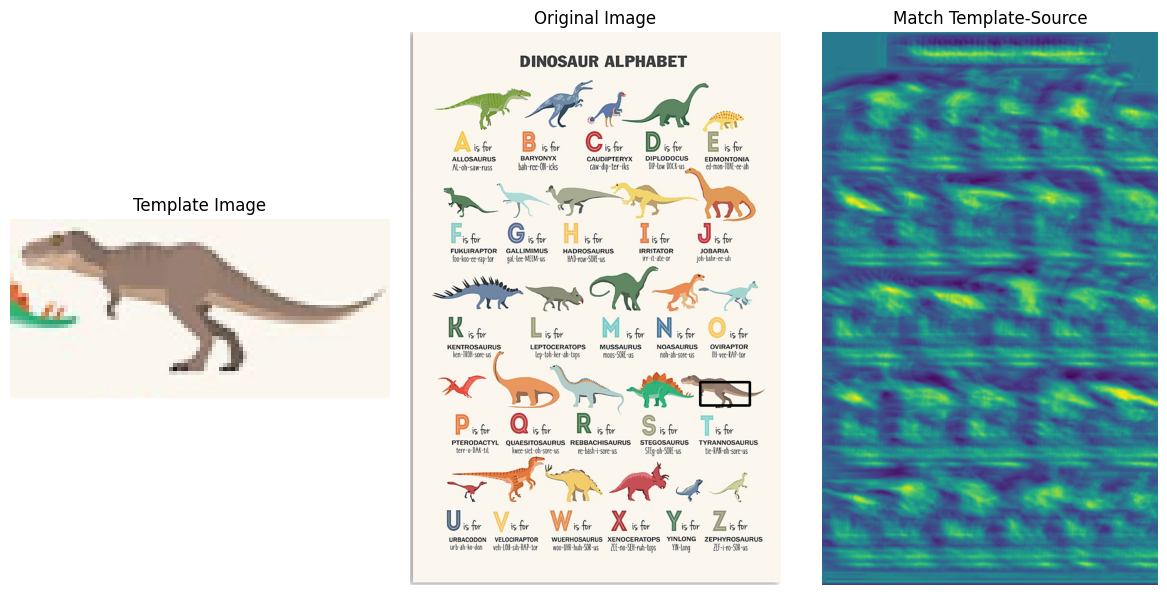

In [14]:
image1 = cv2.imread('/home/fedosdan2/Study/PAC/laba1/image/abc.png')
template = cv2.imread('/home/fedosdan2/Study/PAC/laba1/image/template/1_3.png')

image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

match_source1 = cv2.matchTemplate(image1_rgb, template_rgb, cv2.TM_CCOEFF_NORMED)

h, w = template.shape[:2]
max_match1 = np.where(match_source1 == match_source1.max())
top_left1 = (max_match1[1][0], max_match1[0][0])
bottom_right1 = (top_left1[0] + w, top_left1[1] + h)

result1 = image1_rgb.copy()
cv2.rectangle(result1, top_left1, bottom_right1, color=(0, 0, 0), thickness=3)


# Настройка фигуры: 1 строка, 2 колонки, размер 12x6
plt.figure(figsize=(12, 6))

# 1-е изображение (Слева)
plt.subplot(1, 3, 1)  # (строки, колонки, номер_ячейки)
plt.imshow(template_rgb)
plt.title('Template Image')
plt.axis('off')

# 2-е изображение
plt.subplot(1, 3, 2)
plt.imshow(result1)
plt.title('Original Image')
plt.axis('off')

# 3-е изображение (Справа)
plt.subplot(1, 3, 3)
plt.imshow(match_source1)
plt.title('Match Template-Source')
plt.axis('off')

plt.tight_layout()  # Автоматическая подгонка отступов
plt.show()

Работа OpenCV matchTemplate на шаблоне и тестовом изображении

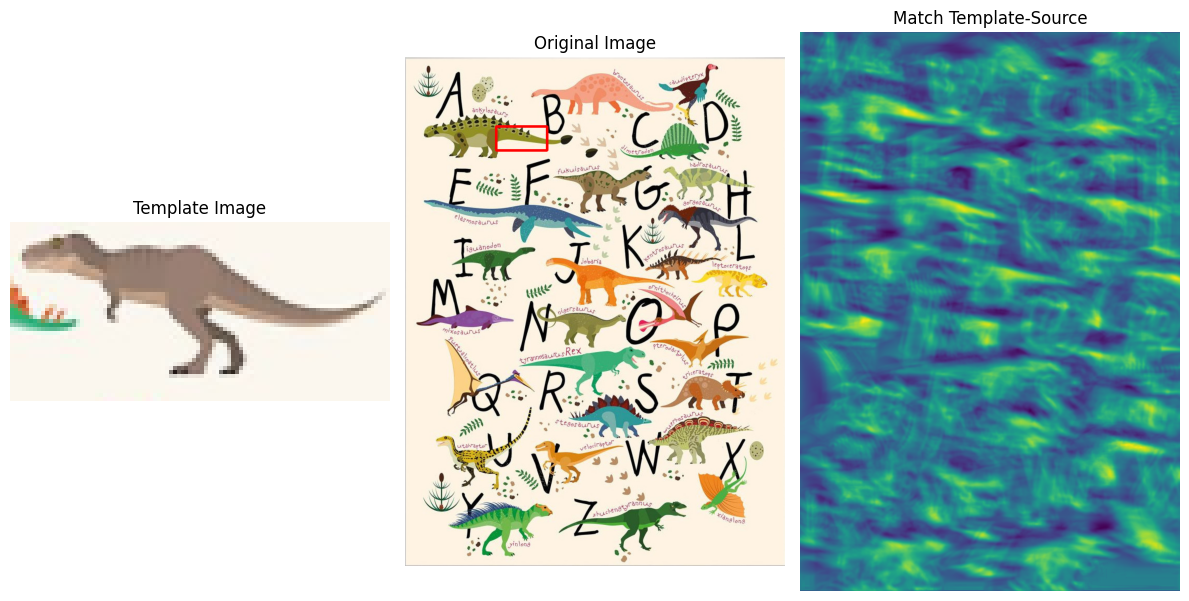

In [15]:
image2 = cv2.imread('/home/fedosdan2/Study/PAC/laba1/image/A_B_C.jpg')
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
match_source2 = cv2.matchTemplate(image2_rgb, template_rgb, cv2.TM_CCOEFF_NORMED)

max_match2 = np.where(match_source2 == match_source2.max())
top_left2 = (max_match2[1][0], max_match2[0][0])
bottom_right2 = (top_left2[0] + w, top_left2[1] + h)

result2 = image2_rgb.copy()
cv2.rectangle(result2, top_left2, bottom_right2, color=(255, 0, 0), thickness=3)

# Настройка фигуры: 1 строка, 2 колонки, размер 12x6
plt.figure(figsize=(12, 6))

# 1-е изображение (Слева)
plt.subplot(1, 3, 1)  # (строки, колонки, номер_ячейки)
plt.imshow(template_rgb)
plt.title('Template Image')
plt.axis('off')

# 2-е изображение
plt.subplot(1, 3, 2)
plt.imshow(result2)
plt.title('Original Image')
plt.axis('off')

# 3-е изображение (Справа)
plt.subplot(1, 3, 3)
plt.imshow(match_source2)
plt.title('Match Template-Source')
plt.axis('off')

plt.tight_layout()  # Автоматическая подгонка отступов
plt.show()

In [16]:
import torchvision
import torch

In [17]:
model = torchvision.models.resnet18(pretrained=True)
model.eval()
layer4_freatures_image1 = None
layer4_freatures_image2 = None
avgpool_features_template = None

def get_features(module, inputs, output):
    global saved_features
    saved_features = output

# форвард хук
model.layer4.register_forward_hook(get_features)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Извлекаем признаки динозавра
input_tensor_template = preprocess(template_rgb)
with torch.no_grad():
    model(input_tensor_template[None,:,:,:])
    template_features = saved_features.clone()
template_features.shape

torch.Size([1, 512, 2, 4])

In [19]:
# Извлекаем признаки динозавра
input_tensor_image1 = preprocess(image1_rgb)
with torch.no_grad():
    model(input_tensor_image1[None,:,:,:])
    image1_features = saved_features.clone()
image1_features.shape


torch.Size([1, 512, 35, 23])

In [20]:
# Извлекаем признаки динозавра
input_tensor_image2 = preprocess(image2_rgb)
with torch.no_grad():
    model(input_tensor_image2[None,:,:,:])
    image2_features = saved_features.clone()
print(image2_rgb.shape)
image2_features.shape

(978, 731, 3)


torch.Size([1, 512, 31, 23])

Проверка ResNet на сопоставлении с основной картинкой

(34, 20)


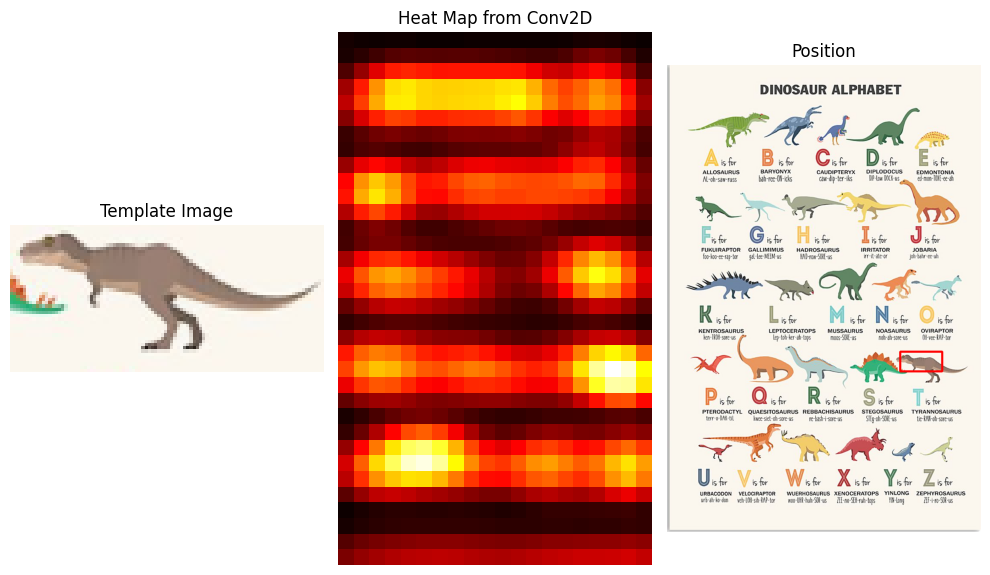

In [23]:
import torch.nn.functional as F

heat_map = F.conv2d(image1_features, template_features)
heat_map_np = heat_map.detach().cpu().numpy()[0, 0, :, :]
print(heat_map_np.shape)

max_match_resnet1 = np.where(heat_map_np==heat_map_np.max())
top_left_resnet1 = (max_match_resnet1[1][0]*32, max_match_resnet1[0][0]*32)
bottom_right_resnet1 = (top_left_resnet1[0] + w, top_left_resnet1[1] + h)

result_resnet1 = image1_rgb.copy()
cv2.rectangle(result_resnet1, top_left_resnet1, bottom_right_resnet1, color=(255, 0, 0), thickness=3)
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)  # (строки, колонки, номер_ячейки)
plt.imshow(template_rgb)
plt.title('Template Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heat_map_np, cmap='hot')
plt.title('Heat Map from Conv2D')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_resnet1)
plt.title('Position')
plt.axis('off')


plt.tight_layout()
plt.show()

Проверка ResNet на сопоставлении с другой картинкой

(30, 20)


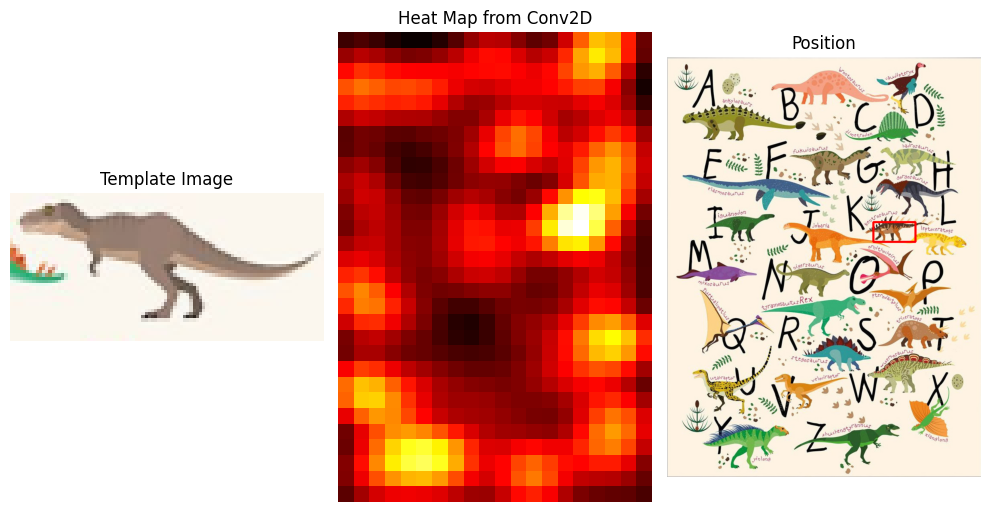

In [24]:
heat_map = F.conv2d(image2_features, template_features)
heat_map_np = heat_map.detach().cpu().numpy()[0, 0, :, :]
print(heat_map_np.shape)

max_match_resnet2 = np.where(heat_map_np==heat_map_np.max())
top_left_resnet2 = (max_match_resnet2[1][0]*32, max_match_resnet2[0][0]*32)
bottom_right_resnet2 = (top_left_resnet2[0] + w, top_left_resnet2[1] + h)

result_resnet2 = image2_rgb.copy()
cv2.rectangle(result_resnet2, top_left_resnet2, bottom_right_resnet2, color=(255, 0, 0), thickness=3)
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)  # (строки, колонки, номер_ячейки)
plt.imshow(template_rgb)
plt.title('Template Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heat_map_np, cmap='hot')
plt.title('Heat Map from Conv2D')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_resnet2)
plt.title('Position')
plt.axis('off')


plt.tight_layout()
plt.show()